# Data augmentation on Google Flower Photos 
"https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 

In [2]:
# download google flower pictures - this will take some time! 
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dataset_loc = keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='data/video26', untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1011s 4us/step


In [3]:
# this is the location where the flower pictures are downloaded and stored 
dataset_loc 

'data/video26/datasets/flower_photos'

In [4]:
import pathlib

dataset_loc = pathlib.Path(dataset_loc)
dataset_loc

PosixPath('data/video26/datasets/flower_photos')

In [7]:
len(list(dataset_loc.glob('*/*.jpg')))

3670

In [9]:
roses = list(dataset_loc.glob('roses/*'))
len(roses)

641

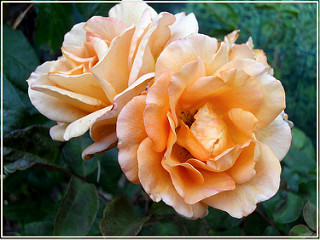

In [12]:
import PIL
PIL.Image.open(roses[2])

In [15]:
tulips = list(dataset_loc.glob('tulips/*'))
len(tulips)

799

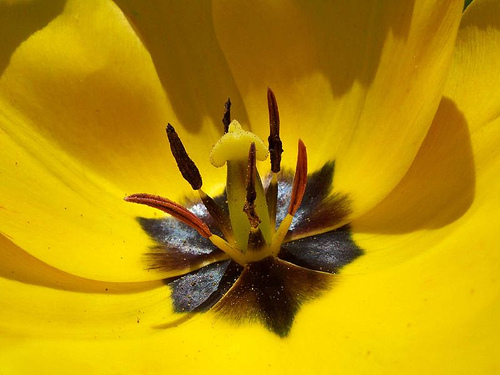

In [21]:
PIL.Image.open(tulips[5])

In [19]:
# list out all the directory names in dataset_loc pathlib 
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        print(dir_name.name)

roses
sunflowers
daisy
dandelion
tulips


In [22]:
# Create a dictonary of all the flowers and lookup name 
flower_images_dict = {}
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        flower_images_dict[dir_name.name] = list(dataset_loc.glob(f'{dir_name.name}/*'))

In [26]:
flower_images_dict.keys()

dict_keys(['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'])

In [27]:
# create another dictionary with flower name and labels 
flower_labels_dict = {}
count = 0
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        flower_labels_dict[dir_name.name] = count
        count+=1

flower_labels_dict

{'roses': 0, 'sunflowers': 1, 'daisy': 2, 'dandelion': 3, 'tulips': 4}

```
Convert these images to numpy array with pixel density 

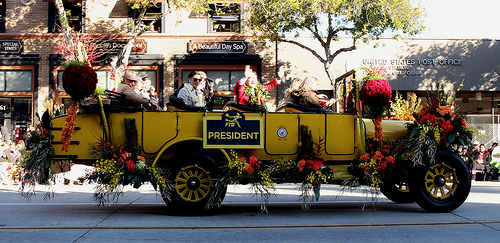

In [34]:
PIL.Image.open(flower_images_dict['roses'][0])

In [38]:
# Now images are in JPG Format. How to convert this image to numpy array? Use CV2 
import cv2 

# testing 
img = cv2.imread(flower_images_dict['roses'][0])
img

array([[[ 14,   3,   0],
        [  1,   0,   2],
        [  0,   0,   6],
        ...,
        [244, 245, 243],
        [244, 245, 243],
        [244, 245, 243]],

       [[  0,   0,   9],
        [  0,   0,   4],
        [  4,   7,   5],
        ...,
        [243, 244, 242],
        [243, 244, 242],
        [243, 244, 242]],

       [[  3,  57, 164],
        [ 30,  63, 132],
        [  0,   0,  19],
        ...,
        [244, 245, 243],
        [244, 245, 243],
        [244, 245, 243]],

       ...,

       [[140, 105,  85],
        [146, 112,  89],
        [147, 113,  90],
        ...,
        [155, 125,  96],
        [152, 122,  93],
        [148, 118,  89]],

       [[148, 114,  91],
        [152, 118,  95],
        [150, 116,  93],
        ...,
        [154, 124,  95],
        [152, 122,  93],
        [150, 120,  93]],

       [[153, 119,  96],
        [154, 120,  97],
        [149, 115,  91],
        ...,
        [151, 122,  95],
        [153, 123,  94],
        [151, 121,  94]]

In [39]:
img.shape

(243, 500, 3)

``` 
Lets see this image 


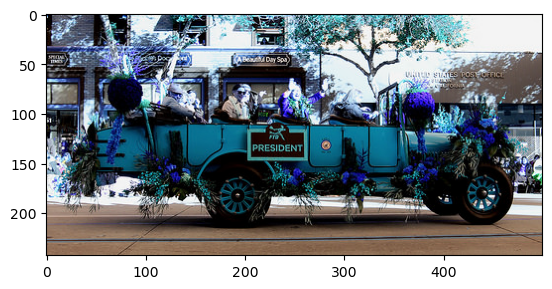

In [40]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 

plt.imshow(img)

```
Every image will be 3D vectors. But the dimensions will not be same. Use cv2.resize as ML models expects all inputs to be in same dimensions

In [41]:
# resize the image to 180x180 
img = cv2.resize(img, (180, 180))

In [42]:
img.shape

(180, 180, 3)

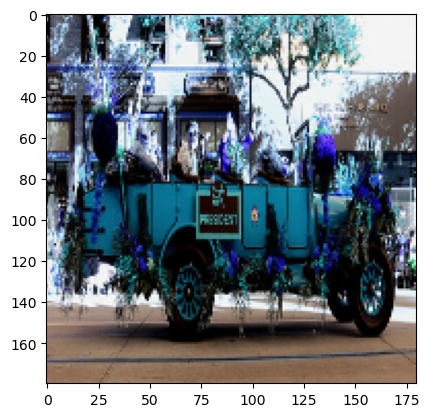

In [33]:
plt.imshow(img)

``` 
We will convert all images to numpy array and resize them 

In [44]:
X, y = [], [] 

# loop over the image dictionary 
for flower_name, image_list in flower_images_dict.items():
    for image in image_list:
        img = cv2.imread(image)
        resized = cv2.resize(img, (180, 180))
        X.append(resized)
        y.append(flower_labels_dict.get(flower_name))

In [50]:
y[0:6], y[649:655]

([0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1])

In [51]:
# convert the X and y to numpy array 
X = np.array(X)
y = np.array(y)

In [ ]:
# perform test train split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2752, 180, 180, 3), (918, 180, 180, 3), (2752,), (918,))

``` 
Perform Data scaling 

In [54]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0 

In [59]:
# Now we have scaled input of common dimensions we are ready to train our model 
model_a = keras.models.Sequential() 

# CNN Layers 
model_a.add(keras.layers.Conv2D(16, 3, padding="same", activation="relu"))
model_a.add(keras.layers.MaxPooling2D())
model_a.add(keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
model_a.add(keras.layers.MaxPooling2D())
model_a.add(keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model_a.add(keras.layers.MaxPooling2D())

# ANN Layer 
model_a.add(keras.layers.Flatten())
model_a.add(keras.layers.Dense(128, activation="relu"))
model_a.add(keras.layers.Dense(5))

# Compile the model 
model_a.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=keras.optimizers.Adam(), metrics=["accuracy"])


2025-06-21 22:17:07.543119: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-21 22:17:07.543279: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-21 22:17:07.543285: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-21 22:17:07.543337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-21 22:17:07.543365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [60]:
model_a.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
# train the model 
model_a.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10


2025-06-21 22:18:58.723030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3186 - loss: 1.9362
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5711 - loss: 1.0940
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6783 - loss: 0.8619
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7272 - loss: 0.7235
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8167 - loss: 0.4726
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8718 - loss: 0.3658
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9174 - loss: 0.2589
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8988 - loss: 0.3665
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8676 - loss: 0.5537
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9149 - loss: 0.2345


In [62]:
model_a.evaluate(X_test_scaled, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5965 - loss: 2.1687


[2.129911422729492, 0.5925925970077515]

``` 
Model is clearly overfitting

In [63]:
# lets do some predictions 
y_pred = model_a.predict(X_test_scaled)
y_pred[:10]

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[ 6.207596  , -0.70410687,  0.30176514, -3.4953704 , 16.675766  ],
       [-2.572276  ,  6.80144   , -1.8325961 , -1.7429314 , -0.32144853],
       [-4.435467  , -9.935736  , -2.7043977 , -2.7598248 , -1.2963247 ],
       [-6.9324555 , -6.326485  , -4.387378  ,  4.1293545 , -2.79904   ],
       [-5.371937  , -5.0412593 , -7.463376  , -1.5610342 , -3.821845  ],
       [-1.8132033 , -0.45132697, -2.8232858 , -7.4842887 , -1.2872186 ],
       [-3.5032284 , -5.5158334 ,  5.828243  , -2.1128788 , -2.0322745 ],
       [13.568041  , -6.761952  , 15.338484  ,  2.386242  ,  5.024936  ],
       [ 2.6706254 , -2.4121068 , -3.005557  ,  4.4305944 ,  3.5633538 ],
       [ 0.05523778,  5.886395  ,  0.6786353 , -3.4296374 , 11.419455  ]],
      dtype=float32)

``` 
Since we didn't provide activation for output layer - it defaulted to linear activation and therefore values are appearning. We can use tensorflow softmax to get the scores 

In [64]:
y_scores = tf.nn.softmax(y_pred)
y_scores[:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[2.8426215e-05, 2.8314215e-08, 7.7419351e-08, 1.7368973e-09,
        9.9997151e-01],
       [8.4819963e-05, 9.9873763e-01, 1.7772033e-04, 1.9439198e-04,
        8.0541620e-04],
       [2.8508665e-02, 1.1647707e-04, 1.6097954e-01, 1.5229967e-01,
        6.5809560e-01],
       [1.5681437e-05, 2.8744545e-05, 1.9984737e-04, 9.9877745e-01,
        9.7837474e-04],
       [1.9077223e-02, 2.6553791e-02, 2.3562131e-03, 8.6212277e-01,
        8.9890003e-02],
       [1.4361073e-01, 5.6058604e-01, 5.2301444e-02, 4.9461325e-04,
        2.4300720e-01],
       [8.8517256e-05, 1.1829457e-05, 9.9915886e-01, 3.5550789e-04,
        3.8534979e-04],
       [1.4548282e-01, 2.1557989e-10, 8.5448682e-01, 2.0259006e-06,
        2.8352326e-05],
       [1.0794859e-01, 6.6959852e-04, 3.6989819e-04, 6.2742496e-01,
        2.6358697e-01],
       [1.1557264e-05, 3.9381697e-03, 2.1557247e-05, 3.5431762e-07,
        9.9602842e-01]], dtype=float32)>

In [65]:
# Now perform argmax to get the index of classification 
y_class = [np.argmax(i) for i in y_scores]
y_class[:5]

[4, 1, 4, 3, 3]

In [66]:
y_test[:5]

array([0, 3, 2, 3, 3])

# Creating augmentation layer

In [88]:
data_agumentation = keras.models.Sequential()
# data_agumentation.add(keras.layers.RandomZoom(0.9))
# data_agumentation.add(keras.layers.RandomContrast(0.9))
data_agumentation.add(keras.layers.RandomRotation(0.2))

```
RandomZoom

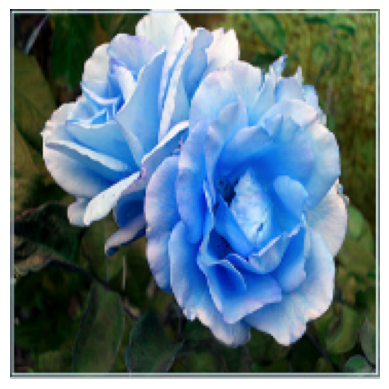

In [82]:
plt.axis("off")
plt.imshow(X[2])

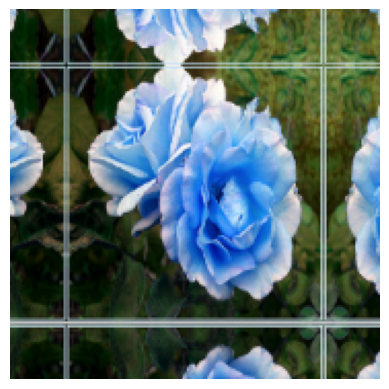

In [83]:
# lets apply  data augmentation for randomzoom=0.9
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

```
Random Constrast

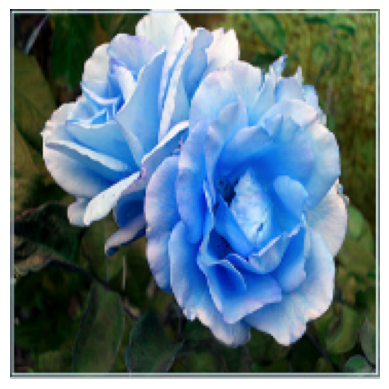

In [86]:
plt.axis("off")
plt.imshow(X[2])

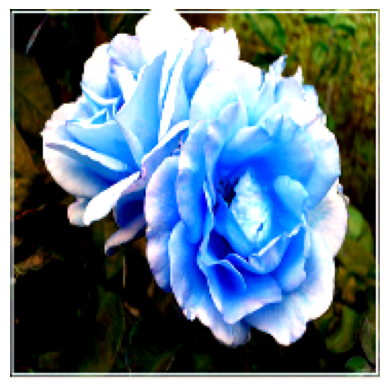

In [87]:
# lets apply  data augmentation for randomzoom=0.9
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

``` 
Random rotation 

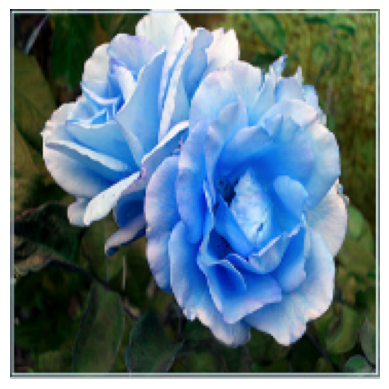

In [89]:
plt.axis("off")
plt.imshow(X[2])

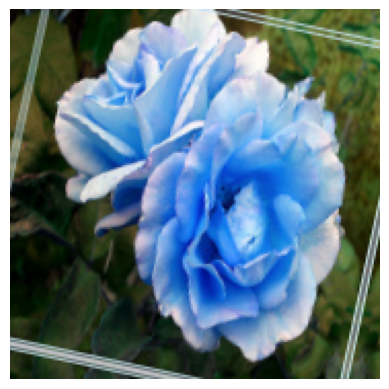

In [90]:
# lets apply  data augmentation for randomzoom=0.9
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

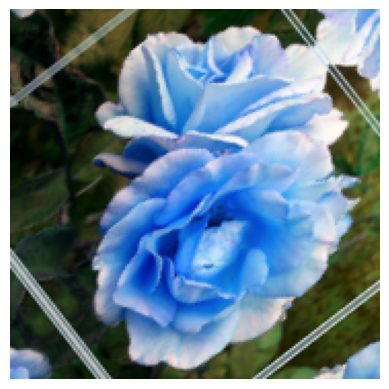

In [91]:
# lets apply  data augmentation for randomratotation again 
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

``` 
Create Data Augmentation Layer

In [93]:
data_augmentation_1 = keras.models.Sequential() 
data_augmentation_1.add(keras.layers.RandomFlip("horizontal", input_shape=(180,180,3)))
data_augmentation_1.add(keras.layers.RandomRotation(0.1))
data_augmentation_1.add(keras.layers.RandomZoom(0.1))

/Users/rohitabhishek/miniconda3/envs/mlenv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


``` 
Build the model 

In [99]:
# Now we have scaled input of common dimensions we are ready to train our model 
model_b = keras.models.Sequential() 

# Data Augmentation Layer 
model_b.add(data_augmentation_1)

# CNN Layers 
model_b.add(keras.layers.Conv2D(16, 3, padding="same", activation="relu"))
model_b.add(keras.layers.MaxPooling2D())
model_b.add(keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
model_b.add(keras.layers.MaxPooling2D())
model_b.add(keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model_b.add(keras.layers.MaxPooling2D())

# Add a dropout layer
model_b.add(keras.layers.Dropout(0.2))

# ANN Layer 
model_b.add(keras.layers.Flatten())
model_b.add(keras.layers.Dense(128, activation="relu"))
model_b.add(keras.layers.Dense(5))

# Compile the model 
model_b.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=keras.optimizers.Adam(), metrics=["accuracy"])


In [100]:
model_b.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# train the model 
model_b.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2774 - loss: 1.9318
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5335 - loss: 1.1321
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5799 - loss: 1.0651
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5739 - loss: 1.0849
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5710 - loss: 1.1329
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5334 - loss: 1.3832
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3972 - loss: 3.6995
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4858 - loss: 1.6812
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5409 - loss: 1.3960
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5496 - loss: 1.2421
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5531 - loss: 1.1829
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy:

In [102]:
# lets see what is the score on test dataset 
model_b.evaluate(X_test_scaled, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5883 - loss: 2.5747


[2.488654375076294, 0.5762526988983154]

``` 
Not very amazing performance but it is not overfitting anymore!